# Tutorial 5 - Restauración de imágenes

En este tutorial veremos algunos conceptos relacionados la restauración de imágenes. En particular veremos:

- Restauración bajo desplazamientos horizontales (1D)
- Restauración bajo desplazamientos en 2D usando el dominio de la frecuencia

In [ ]:
!pip install scikit-image

In [1]:
import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt
import skimage.restoration as restoration

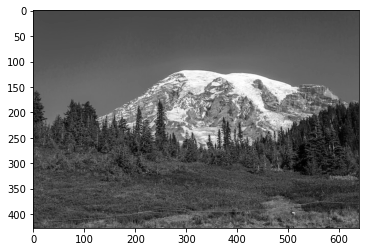

In [2]:
original_im = cv2.imread('landscape.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(original_im, cmap='gray')

# Degradación Horizontal

## Degradar imagen

In [3]:
len_degradation_kernel = 20
hor_degradation_kernel = np.ones(len_degradation_kernel) / len_degradation_kernel
hor_degradation_kernel.shape

(20,)

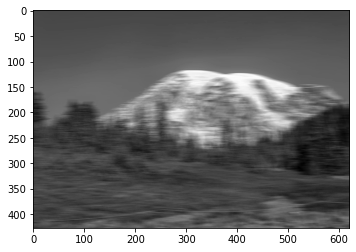

In [4]:
M = original_im.shape[1]
N = M - len_degradation_kernel + 1

hor_degradated_im = cv2.filter2D(original_im, -1, hor_degradation_kernel.reshape(1, len_degradation_kernel))
# Eliminar los bordes que OpenCV crea
hor_degradated_im = hor_degradated_im[:, :N]

plt.imshow(hor_degradated_im, cmap='gray')

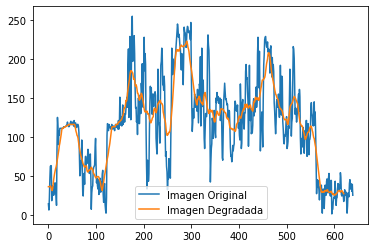

In [5]:
example_line_ix = 200
example_line_original = original_im[example_line_ix, :]
example_line_degradated = hor_degradated_im[example_line_ix, :]

plt.plot(example_line_original, label='Imagen Original')
plt.plot(example_line_degradated, label='Imagen Degradada')
plt.legend()

## Restauración de una línea

In [6]:
# H tiene que ser una matriz de NxM que contenga el kernel en la diagonal
H = np.zeros((N, M))
for i in range(N):
    H[i, i:i+len_degradation_kernel] = hor_degradation_kernel
H

array([[0.05, 0.05, 0.05, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.05, 0.05, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.05, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.05, 0.05, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.05, 0.05, 0.05]])

In [8]:
lambd = 1e6
W = np.eye(M)
A = lambd * np.linalg.inv(lambd * H.T.dot(H) + W.T.dot(W)).dot(H.T)

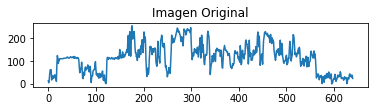

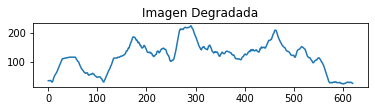

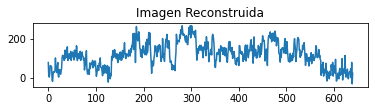

In [9]:
example_line_recontr = A.dot(example_line_degradated)

plt.subplot(311)
plt.title('Imagen Original')
plt.plot(example_line_original)
plt.show()

plt.subplot(312)
plt.title('Imagen Degradada')
plt.plot(example_line_degradated)
plt.show()


plt.subplot(313)
plt.title('Imagen Reconstruida')
plt.plot(example_line_recontr)
plt.show()

## Restauración de la imagen

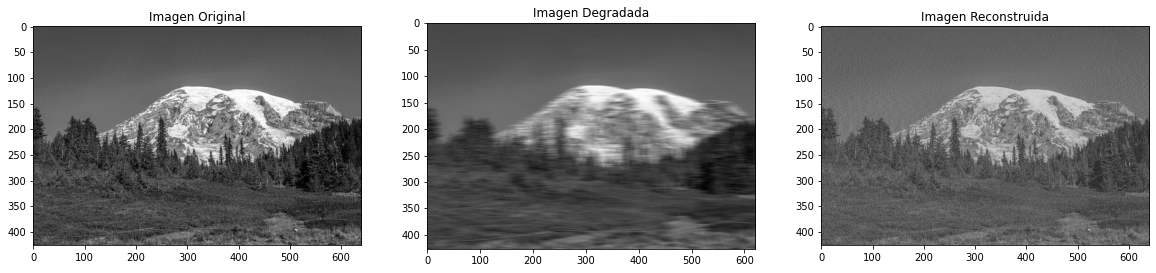

In [10]:
reconstructed_im = hor_degradated_im.dot(A.T)

plt.figure(figsize=(20,20))

plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(original_im, cmap='gray')
plt.subplot(132)
plt.title('Imagen Degradada')
plt.imshow(hor_degradated_im, cmap='gray')
plt.subplot(133)
plt.title('Imagen Reconstruida')
plt.imshow(reconstructed_im, cmap='gray')

# Degradación 2D - Deconvolución

## Degradar imagen

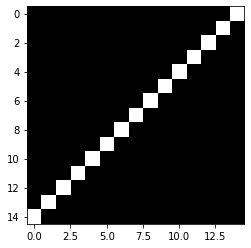

In [11]:
len_degradation_kernel = 15
diag_kernel = np.fliplr(np.eye(len_degradation_kernel)) / len_degradation_kernel
plt.imshow(diag_kernel, cmap='gray')

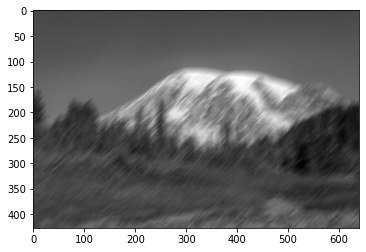

In [12]:
diag_degradated_im = cv2.filter2D(original_im, -1, diag_kernel)

plt.imshow(diag_degradated_im, cmap='gray')

## Deconvolución Naïve

In [13]:
A, B = diag_degradated_im.shape
C, D = diag_kernel.shape

P = A + C + 1
Q = B + D + 1

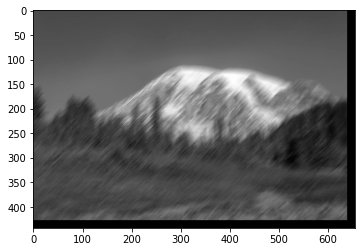

In [14]:
padded_im = np.zeros((P, Q))
padded_im[:A, :B] = diag_degradated_im
plt.imshow(padded_im, cmap='gray')

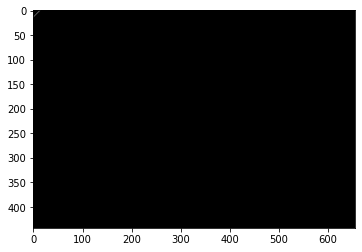

In [15]:
padded_kernel = np.zeros((P, Q))
padded_kernel[:C, :D] = diag_kernel
plt.imshow(padded_kernel, cmap='gray')

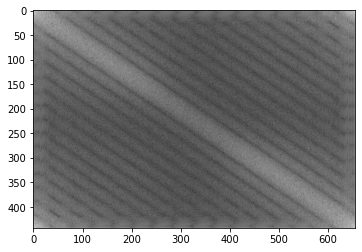

In [16]:
fft_deg = np.fft.fft2(padded_im)
plt.imshow(np.log(np.abs(fft_deg)), cmap='gray')

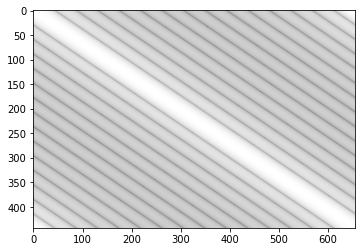

In [17]:
fft_kernel = np.fft.fft2(padded_kernel)
plt.imshow(np.log(np.abs(fft_kernel)), cmap='gray')

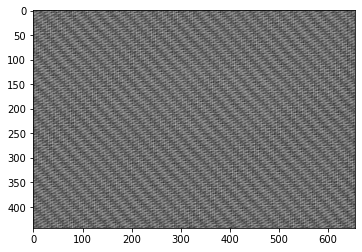

In [18]:
fft_reconstructed = fft_deg / fft_kernel
reconstructed_im = np.real(np.fft.ifft2(fft_reconstructed))

plt.imshow(reconstructed_im, cmap='gray')

## Deconvolución: 2do intento

Siguiendo la formulación vista en clase, buscamos alternativas que traten de suavizar el ruido. En este caso usaremos la reformulación $$W(u,v)=\frac{H^*(u, v)}{|H(u,v)|^2 + R}$$ y probaremos distintos valores de R 

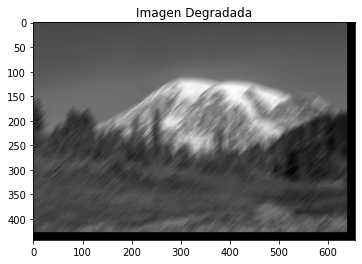

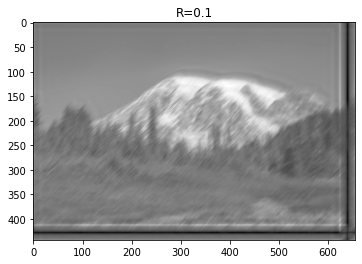

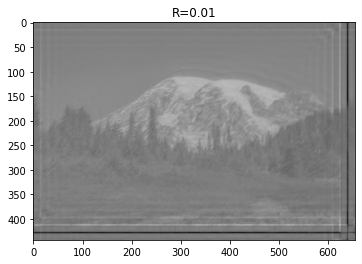

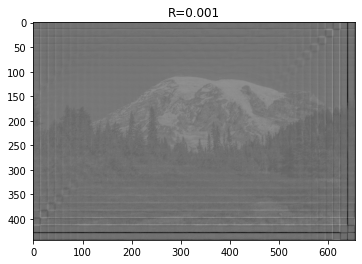

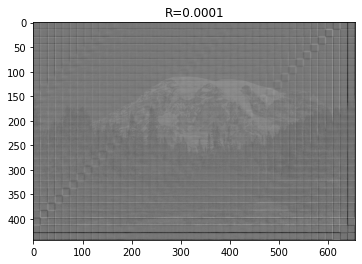

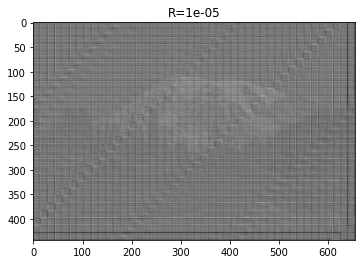

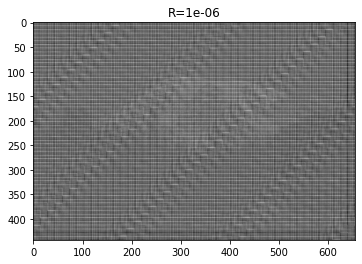

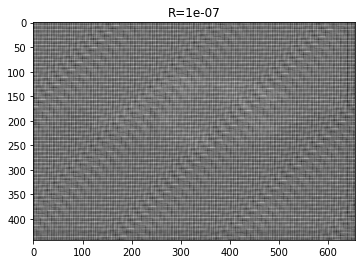

In [19]:
plt.title('Imagen Degradada')
plt.imshow(padded_im, cmap='gray')
plt.show()

for r in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]:
    W = fft_kernel.conjugate() / (np.abs(fft_kernel)**2 + r)
    fft_reconstructed = fft_deg * W
    reconstructed_im = np.real(np.fft.ifft2(fft_reconstructed))

    plt.title(f'R={r}')
    plt.imshow(reconstructed_im, cmap='gray')
    plt.show()

## Deconvolución de Wiener

Ahora verremos la implementación de la deconvolición de Weiner. Este es un caso particular de la deconvulución vista en clase que utiliza el el Signal-Noise Ratio para penalizar las frecuencias altas y así evitar divisiones por 0.

In [21]:
reconstructed_wiener, _ = restoration.unsupervised_wiener(diag_degradated_im / 255, diag_kernel)

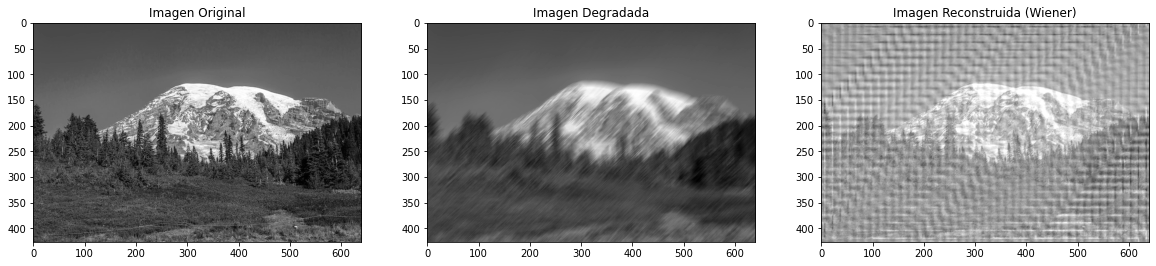

In [22]:
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(original_im, cmap='gray')
plt.subplot(132)
plt.title('Imagen Degradada')
plt.imshow(diag_degradated_im, cmap='gray')
plt.subplot(133)
plt.title('Imagen Reconstruida (Wiener)')
plt.imshow(reconstructed_wiener, cmap='gray')

## Deconvolución de Richardson-Lucy

In [23]:
reconstructed_rl = restoration.richardson_lucy(diag_degradated_im / 255, diag_kernel, num_iter=100)

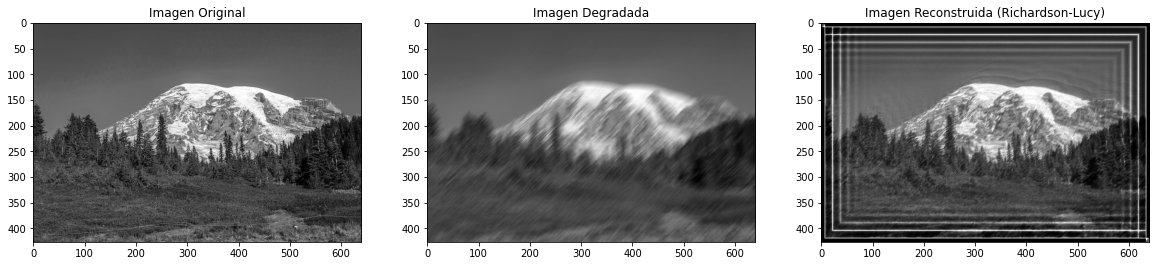

In [24]:
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(original_im, cmap='gray')
plt.subplot(132)
plt.title('Imagen Degradada')
plt.imshow(diag_degradated_im, cmap='gray')
plt.subplot(133)
plt.title('Imagen Reconstruida (Richardson-Lucy)')
plt.imshow(reconstructed_rl, cmap='gray')